# Supplier Cost Anomaly Detection

Starter notebook. Follow the steps below and add your analysis.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/supplier_cost.csv')
df.head()

,supplier,style_id,process_count,total_cost,smv,fabric_cost,sewing_cost,logistics_cost
0,Supplier_D,S015,15,5.12,24.11,2.73,0.61,1.77
1,Supplier_C,S004,12,4.83,8.56,3.34,1.29,0.21
2,Supplier_B,S001,14,4.10,19.66,2.00,0.91,1.19
3,Supplier_B,S016,7,3.53,34.55,1.91,0.96,0.66
4,Supplier_E,S009,11,2.05,33.44,1.17,0.36,0.52


## TODO
1. Explore distributions (boxplots, histograms)
2. Create derived ratio columns
3. Implement anomaly detection (IQR or Isolation Forest)
4. Tag cost structures
5. Save results to `../output/`

In [4]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   supplier        100 non-null    object 
 1   style_id        100 non-null    object 
 2   process_count   100 non-null    int64  
 3   total_cost      100 non-null    float64
 4   smv             100 non-null    float64
 5   fabric_cost     100 non-null    float64
 6   sewing_cost     100 non-null    float64
 7   logistics_cost  100 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 6.4+ KB


supplier          0
style_id          0
process_count     0
total_cost        0
smv               0
fabric_cost       0
sewing_cost       0
logistics_cost    0
dtype: int64

In [5]:
df.describe()


,process_count,total_cost,smv,fabric_cost,sewing_cost,logistics_cost
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,10.190000,3.918600,22.840200,2.158700,0.801200,0.958900
std,3.362584,1.164723,7.450605,0.755493,0.339219,0.502808
min,5.000000,2.020000,8.390000,0.930000,0.230000,0.080000
25%,7.000000,2.960000,17.052500,1.615000,0.557500,0.607500
50%,10.500000,3.855000,23.360000,2.000000,0.710000,0.850000
75%,13.000000,4.967500,28.767500,2.655000,0.945000,1.320000
max,15.000000,6.000000,34.910000,3.970000,1.630000,2.290000


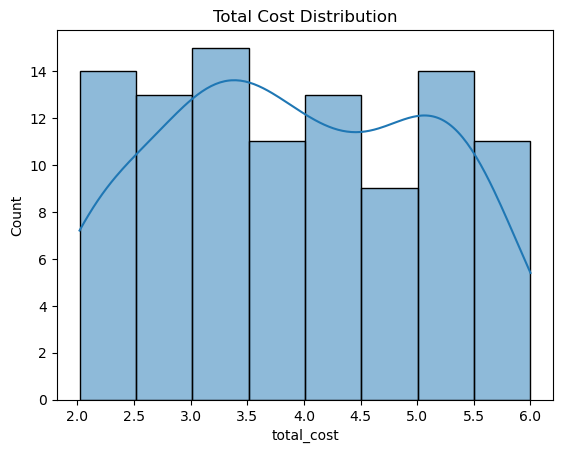

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# total cost distribution
sns.histplot(df['total_cost'], kde=True)
plt.title("Total Cost Distribution")
plt.show()


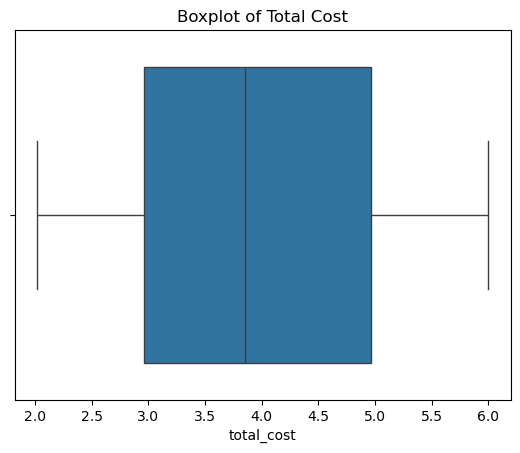

In [8]:
# boxplot
sns.boxplot(x=df['total_cost'])
plt.title("Boxplot of Total Cost")
plt.show()


In [9]:
df['fabric_ratio'] = df['fabric_cost'] / df['total_cost']
df['sewing_ratio'] = df['sewing_cost'] / df['total_cost']
df['logistics_ratio'] = df['logistics_cost'] / df['total_cost']


In [10]:
df.head()

,supplier,style_id,process_count,total_cost,smv,fabric_cost,sewing_cost,logistics_cost,fabric_ratio,sewing_ratio,logistics_ratio
0,Supplier_D,S015,15,5.12,24.11,2.73,0.61,1.77,0.533203,0.119141,0.345703
1,Supplier_C,S004,12,4.83,8.56,3.34,1.29,0.21,0.691511,0.267081,0.043478
2,Supplier_B,S001,14,4.10,19.66,2.00,0.91,1.19,0.487805,0.221951,0.290244
3,Supplier_B,S016,7,3.53,34.55,1.91,0.96,0.66,0.541076,0.271955,0.186969
4,Supplier_E,S009,11,2.05,33.44,1.17,0.36,0.52,0.570732,0.175610,0.253659


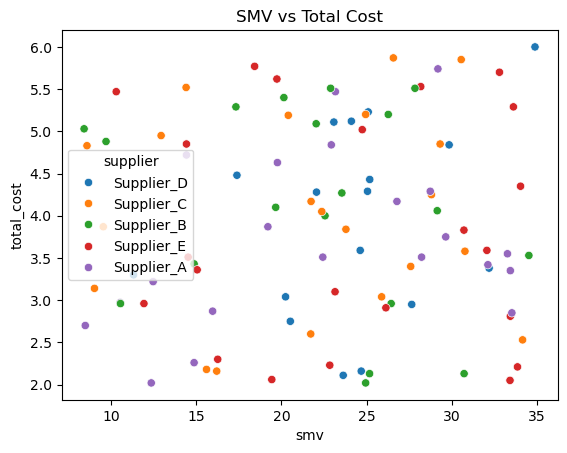

In [12]:
# SMV vs Total Cost
sns.scatterplot(data=df, x="smv", y="total_cost", hue="supplier")
plt.title("SMV vs Total Cost")
plt.show()


In [13]:
df.groupby("supplier")[["total_cost", "fabric_ratio", "sewing_ratio"]].mean().round(2)


,total_cost,fabric_ratio,sewing_ratio
supplier,,,
Supplier_A,3.70,0.54,0.20
Supplier_B,4.08,0.52,0.18
Supplier_C,4.05,0.58,0.22
Supplier_D,3.94,0.54,0.20
Supplier_E,3.84,0.55,0.21


In [14]:
# IQR method for detecting outliers in total_cost
Q1 = df['total_cost'].quantile(0.25)
Q3 = df['total_cost'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers
df['iqr_outlier'] = ((df['total_cost'] < lower_bound) | (df['total_cost'] > upper_bound)).astype(int)

print(f"{df['iqr_outlier'].sum()} outliers detected using IQR method.")


0 outliers detected using IQR method.


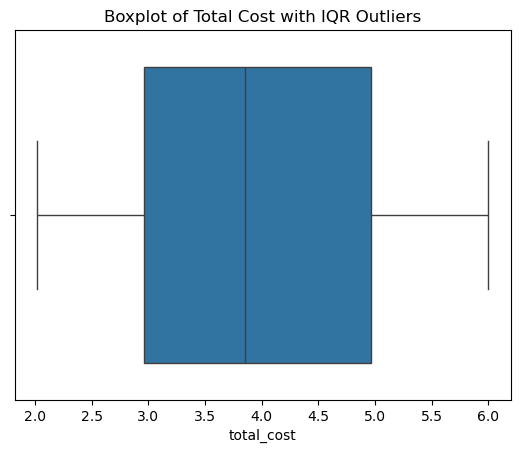

In [15]:
sns.boxplot(x=df['total_cost'])
plt.title("Boxplot of Total Cost with IQR Outliers")
plt.show()

In [17]:
from sklearn.ensemble import IsolationForest

# Select numeric features for modeling
features = ['total_cost', 'smv', 'fabric_ratio', 'sewing_ratio', 'logistics_ratio']
iso = IsolationForest(contamination=0.1, random_state=42)
df['iso_outlier'] = iso.fit_predict(df[features])

# Convert -1 (anomaly) to 1 for easier interpretation
df['iso_outlier'] = (df['iso_outlier'] == -1).astype(int)

print(f"{df['iso_outlier'].sum()} outliers detected using Isolation Forest.")

10 outliers detected using Isolation Forest.


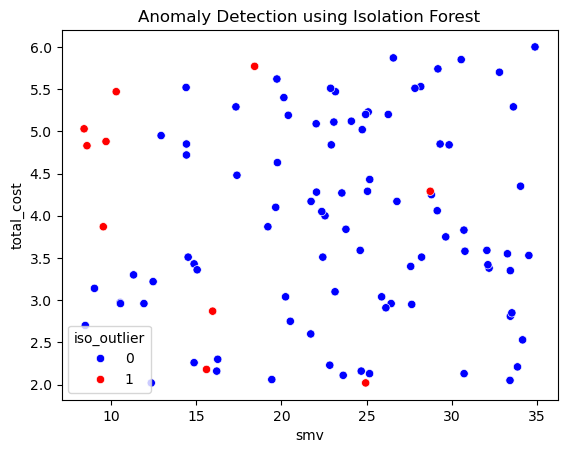

In [18]:
sns.scatterplot(data=df, x="smv", y="total_cost", hue="iso_outlier", palette={0:"blue", 1:"red"})
plt.title("Anomaly Detection using Isolation Forest")
plt.show()

In [20]:
def generate_cost_tags(row):
    tags = []
    if row['fabric_ratio'] > 0.6:
        tags.append("High Fabric Cost")
    if row['logistics_ratio'] > 0.3:
        tags.append("High Logistics Cost")
    if row['sewing_ratio'] < 0.1:
        tags.append("Low Sewing Cost")
    if row['total_cost'] > df['total_cost'].mean() + df['total_cost'].std():
        tags.append("High Overall Cost")
    return ", ".join(tags) if tags else "Normal"

df['cost_tags'] = df.apply(generate_cost_tags, axis=1)

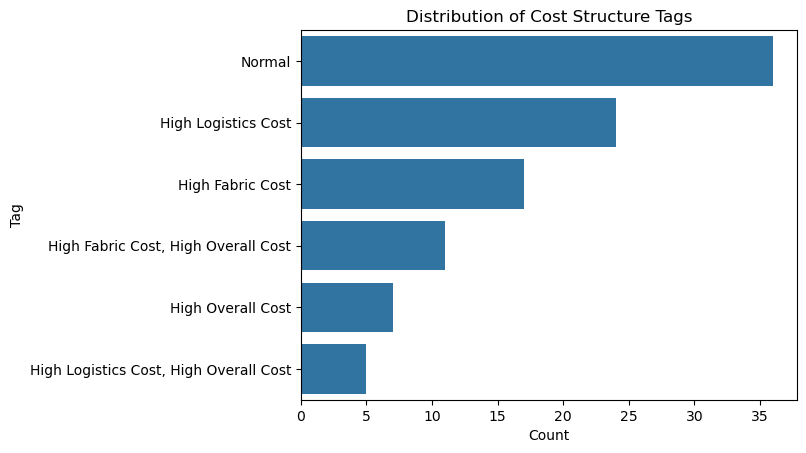

In [21]:
tag_counts = df['cost_tags'].value_counts()
sns.barplot(x=tag_counts.values, y=tag_counts.index)
plt.title("Distribution of Cost Structure Tags")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.show()

In [27]:
df.to_csv("../output/tagged_supplier_cost.csv", index=False)
print("Tagged results saved to output/tagged_supplier_cost.csv")


Tagged results saved to output/tagged_supplier_cost.csv


In [26]:
df.to_csv("../output/tagged_supplier_cost.csv", index=False)
print("Tagged results saved to output/tagged_supplier_cost.csv")

Tagged results saved to output/tagged_supplier_cost.csv


In [28]:
df[['supplier', 'style_id', 'total_cost', 'fabric_ratio', 'logistics_ratio', 'cost_tags']].head(10)


,supplier,style_id,total_cost,fabric_ratio,logistics_ratio,cost_tags
0,Supplier_D,S015,5.12,0.533203,0.345703,"High Logistics Cost, High Overall Cost"
1,Supplier_C,S004,4.83,0.691511,0.043478,High Fabric Cost
2,Supplier_B,S001,4.10,0.487805,0.290244,Normal
3,Supplier_B,S016,3.53,0.541076,0.186969,Normal
4,Supplier_E,S009,2.05,0.570732,0.253659,Normal
5,Supplier_B,S002,2.96,0.584459,0.152027,Normal
6,Supplier_C,S014,3.04,0.493421,0.302632,High Logistics Cost
7,Supplier_B,S004,2.13,0.535211,0.286385,Normal
8,Supplier_D,S014,4.28,0.689252,0.042056,High Fabric Cost
9,Supplier_E,S018,4.35,0.581609,0.262069,Normal
